# Song Corpora Analysis

In [1]:
import csv
import copy
import numpy as np
from collections import Counter
import json

from matplotlib import pyplot as plt

#from __future__ import division

# Allowed Harmony Chords and Melody Notes
# This is for a Major scale, so the Harmony Chords H
#   1,3,5,7 are assumed major chords relative to the tonic - the minors will get an added 'm', and
#   2,4,6  are assumed to be minor chords - the major will get an added 'M'
#   An added '7' denotes a chord with the seventh tone.
# For notes and chords out of key I use '#' and 'f'

H = ['1', '17', '2', '2M', '27', '2M7', '3', '37', '3m', '4', '4M', 
     '5', '57', '6', '6M', '67', '6M7', '7', '7f']
M = ['1', '2', '3', '4', '4#', '5', '6', '7', '7f']

## Validate Data
* Check that each measure has 2 tokens
* Check that each token is a valid H-M pair in terms of the universe defined above

Note *even*M7 are okay as they are reduced to *even*7 later.

In [2]:
tokens = [h+'-'+m for h in H for m in M]

#with open('data/H-M Training - Traditional-Orig.csv', 'r') as f:
with open('data/H-M Training - Traditional Irish.csv', 'r') as f:
    reader = csv.reader(f)
    #trainingTuples =  map(tuple, reader)

    allTuples = []
    ones = []
    twos = []
    for i, dataString in enumerate(reader):
        theseTuples = [token.strip() for token in dataString[2:]]
        
        allTuples.extend(theseTuples)
        
        for t in theseTuples:
            try:
                ones.append(t.split(' ')[0][1:])
                twos.append(t.split(' ')[1][:-1])
            except IndexError:
                print('BAD TOKEN in - ' + dataString[0])
                print('Index: ' + str(i))
                print(t + '\n')
            
            try:
                assert(ones[-1] in tokens)
            except AssertionError:
                print('H1 TOKEN Out of Bounds in - ' + dataString[0])
                print('Index: ' + str(i))
                print(ones[-1] + '\n')
                
            try:
                assert(twos[-1] in tokens)
            except AssertionError:
                print('H2 TOKEN Out of Bounds in - ' + dataString[0])
                print('Index: ' + str(i))
                print(twos[-1] + '\n')

print(len(allTuples), 'measures analysed')

1349 measures analysed


## Load songs

In [3]:
def loadSongs(csvFileName):
    with open(csvFileName, 'r') as f:
        reader = csv.reader(f)
        #trainingTuples =  map(tuple, reader)
        
        songs = []
        for dataString in reader:
            song = []
            for measureData in dataString[2:]:
                # Clean up string data
                md = measureData.strip().strip('(').strip(')')
                # Reduce <even>M7 to <even>7
                m1 = md.replace('2M7', '27')
                m2 = m1.replace('4M7', '47')
                m = m2.replace('6M7', '67')
                
                md = m
                m1 = md.replace('4-2', '4M-2')
                m2 = m1.replace('4-4', '4M-4')
                m = m2.replace('4-6', '4M-6')
                
                # Store as tuple to handle as sequence - Markov Chain
                measureTuple = (m.split()[0], m.split()[1])
                song.append(measureTuple)
                
            songs.append(song)
            
    return songs

# Load everything but Irish
csvFileName = 'data/H-M Training - Traditional.csv'
songsA = loadSongs(csvFileName)

# Load Irish
csvFileName = 'data/H-M Training - Traditional Irish.csv'
songsI = loadSongs(csvFileName)

# Combine
songs = songsA + songsI

tuples_h1 = [measure[0] for song in songs for measure in song]
tuples_h2 = [measure[1] for song in songs for measure in song]

tuples = tuples_h1 + tuples_h2

print("Loaded", len(songs), 'songs')
print(len(tuples), 'tuples')

Loaded 89 songs
5378 tuples


# Data Properties
A fundamental unit, a 'token', is a harmony-melody pair.  At this point we don't care if the token on the first bead of the measure (later we call this Half 1) or in the middle of the measure (Half 2).  Here we calculate the following:
* Distribution of tokens (plot)
* Average number of counts per token
* Standard Deviation of counts per token for all tokens
* Number of tokens with no counts

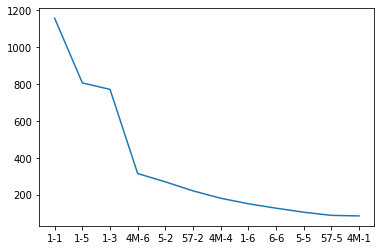

Number of Tokens: 171
Average Number of Counts per Token: 76.83
Standard Deviation of Counts per Token: 190.42
Number of Tokens with no counts: 0
Number of Tokens with 1 count: 6


In [4]:
### 
c = Counter(tuples)

plt.plot([t[0] for t in c.most_common(12)], [t[1] for t in c.most_common(12)])
plt.show()

print('Number of Tokens: ' + '{}'.format(len(tokens)))
mu = np.mean([v for v in c.values()])
print('Average Number of Counts per Token: ' + '{:.2f}'.format(mu))
sigma = np.std([v for v in c.values()])
print('Standard Deviation of Counts per Token: ' + '{:.2f}'.format(sigma))
sparsity = len([v for v in c.values() if v==0])
print('Number of Tokens with no counts: ' + '{}'.format(sparsity))
print('Number of Tokens with 1 count: ' + '{}'.format(len([v for v in c.values() if v==1])))

# Markov Chains
Model the data as a Markov process - each part of a measure idependently, one model for the first token of a measure is dependent upon the prior token, the second model for the token found at the half way point of each measure. 

In [5]:
# Train Markov Models via TransitionMatrix Class
class TransitionMatrix(object):
    def __init__(self):
        self.tokens = [h+'-'+m for h in H for m in M]
        self.sequences = [(t1, t2) for t1 in self.tokens for t2 in self.tokens]
        self.p = np.full((len(self.tokens), len(self.sequences)), 0.0)
        self.p_inv = np.full((len(self.sequences), len(self.tokens)), 0.0)
        self.count = np.zeros((len(self.tokens), len(self.sequences)))
        self.idxByToken = {t:i for i,t in enumerate(self.tokens)}
        self.idxBySequence = {str(t):i for i,t in enumerate(self.sequences)}
    
    def from_json(self, kwargs):
        for key in kwargs:
            if key in ['count', 'p', 'p_inv']:
                setattr(self, key, np.asarray(kwargs[key]))
            else:
                setattr(self, key, kwargs[key])
    
    # Use one type of update for any TM instance.
    # update* writes to count and thus is reflected in p and p_inv
    def update_order1(self, song):
        for measure0, measure1 in zip(song, song[1:]):
            # Add second half measure0 given first half measure0
            token_final = self.idxByToken[measure0[1]]
            token_init = self.idxByToken[measure0[0]]
            self.count[token_final][token_init] += 1
            
            # Add first half measure1 given secong half measure0
            token_final = self.idxByToken[measure1[0]]
            token_init = self.idxByToken[measure0[1]]
            self.count[token_final][token_init] += 1
        self._calc_p()
        
    def update_h1(self, song):
        for measure0, measure1 in zip(song, song[1:]):
            tokenIdx = self.idxByToken[measure1[0]]
            sequenceIdx = self.idxBySequence[str(measure0)]
            self.count[tokenIdx][sequenceIdx] += 1    
        self._calc_p()
    
    def update_h2(self, song):
        for measure0, measure1 in zip(song, song[1:]):
            tokenIdx = self.idxByToken[measure1[1]]
            sequenceIdx = self.idxBySequence[str((measure0[1], measure1[0]))]
            self.count[tokenIdx][sequenceIdx] += 1    
        self._calc_p()
    
    def _calc_p(self):
        for i, t in enumerate(self.tokens):
            total = 0
            for j, s in enumerate(self.sequences):
                total += self.count[i][j]
                
            if total != 0:
                for j, s in enumerate(self.sequences):
                    self.p[i][j] = self.count[i][j]/float(total)
            else:
                self.p[i] = np.full(len(self.sequences), 0.0)
    
    def calc_inv(self):
        self.p_token = [sum(self.p[i,:]) for i, t in enumerate(self.tokens)]
        self.p_sequence = [sum(self.p[:,j]) for j, s in enumerate(self.sequences)]
        for j, s in enumerate(self.sequences):
            prob_dist = np.zeros(len(self.tokens))
            for i, t in enumerate(self.tokens):
                if self.p_token[i]>0.0:
                    prob_dist[i] = self.p[i][j]*self.p_sequence[j]/self.p_token[i]
                
            norm = np.linalg.norm(prob_dist,1)
            if norm != 0: 
                self.p_inv[j,:] = prob_dist / norm
    
    def to_json(self, outfile):
        jsonData=json.dumps(self.__dict__, cls=NumpyEncoder)
        with open(outfile, 'w') as f:
            json.dump(jsonData, f)
            

# Serialize ndarrays to json
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

## Rates of Convergence for MCs of Order 1 and Order 2

## Train transition matricies and plot change vs. amount of training data

In [6]:
# 1. Ingest song (read, revert <even>M7 to <even>7, and convert to sequences)
# 2. Calc TransitionMatrix
# 3. Calc delta
# 4. Store delta and repeat

tm_order1 = TransitionMatrix()
tm_h1 = TransitionMatrix()
tm_h2 = TransitionMatrix()

num_songs = []
delta_order1 = []
delta_h1 = []
delta_h2 = []
p_init = copy.copy(tm_order1.p)
p1_init = copy.copy(tm_h1.p)
p2_init = copy.copy(tm_h2.p)
num_measures=0
for i,song in enumerate(songs):
    num_measures += len(song)
    
    tm_order1.update_order1(song)
    tm_h1.update_h1(song)
    tm_h2.update_h2(song)
    
    if (i+1)%6==0:
        print(str(i) + ' of ' + str(len(songs)))
        num_songs.append(i+1)
        
        delta_order1.append((np.linalg.norm(tm_order1.p - p_init))/num_measures)
                            
        d1 = np.linalg.norm(tm_h1.p - p1_init)
        d2 = np.linalg.norm(tm_h2.p - p2_init)
        delta_h1.append(d1/num_measures)
        delta_h2.append(d2/num_measures)

        p_init = copy.copy(tm_order1.p)
        p1_init = copy.copy(tm_h1.p)
        p2_init = copy.copy(tm_h2.p)
        num_measures = 0
        
tm_order1.calc_inv()
tm_h1.calc_inv()
tm_h2.calc_inv()

5 of 89
11 of 89
17 of 89
23 of 89
29 of 89
35 of 89
41 of 89
47 of 89
53 of 89
59 of 89
65 of 89
71 of 89
77 of 89
83 of 89


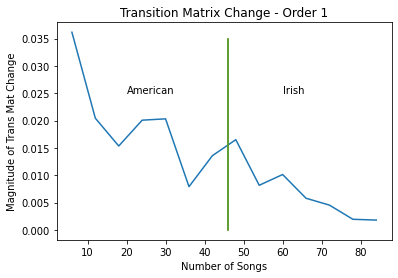

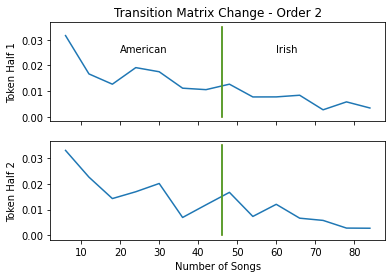

In [7]:
# Load models when not present
# TODO: Fit C*exp(-ax) to estimate how much data is needed to reach 0.1% relative tolerance
plt.plot(num_songs, delta_order1)
plt.title('Transition Matrix Change - Order 1')
plt.xlabel('Number of Songs')
plt.ylabel('Magnitude of Trans Mat Change')
plt.plot([46,46],[0,.035])
plt.plot([46,46],[0,.035])
plt.text(20,.025,'American')
plt.text(60,.025,'Irish')
plt.show()

figure, axes = plt.subplots(nrows=2,ncols=1,sharex=True)
axes[0].plot(num_songs, delta_h1)
axes[1].plot(num_songs, delta_h2)
axes[0].set_title('Transition Matrix Change - Order 2')
plt.xlabel('Number of Songs')
axes[0].set_ylabel('Token Half 1')
axes[1].set_ylabel('Token Half 2')
axes[0].plot([46,46],[0,.035])
axes[0].plot([46,46],[0,.035])
axes[1].plot([46,46],[0,.035])
axes[1].plot([46,46],[0,.035])
axes[0].text(20,.025,'American')
axes[0].text(60,.025,'Irish')
plt.show()

In [9]:
# Write transition matricies to disk
outfile_order1 = "models/allData_tm_order1.json"
outfile_order2_h1 = "models/allData_tm_order2_tm_h1.json"
outfile_order2_h2 = "models/allData_tm_order2_tm_h2.json"
tm_order1.to_json(outfile_order1)
tm_h1.to_json(outfile_order2_h1)
tm_h2.to_json(outfile_order2_h2)

# Tools

## Harmonizer

In [10]:
# A tool to predict a Harmony chord given the current Melody
def harmony(prior, melody):
    # Given a prior H-M and a current melody, guess a harmony chord
    # Most popular case in training data
    # To make a song, predict less popular options based on popularity
    print('Getting best harmony chord after ' + prior + ' for melody ' + melody + ' ...')
    
    pairs = zip(tuples_h1, tuples_h1[1:])
    h0m0m1_h1 = [(pair[0]+'-'+pair[1].split('-')[1], pair[1].split('-')[0]) for pair in pairs]

    c = Counter(h0m0m1_h1)
    #print(c.most_common(5))
    
    candidates={}
    for k in c.keys():
        if k[0] == prior + '-' + melody:
            candidates[k[1]] = c[k]
    
    print('Candidates: ' + str(candidates))
    try:
        best = max(candidates, key=candidates.get)
    except:
        best = 'unknown'
        
    return best

n = harmony('1-3', '5')
print(n)

Getting best harmony chord after 1-3 for melody 5 ...
Candidates: {'1': 71, '2': 3, '5': 2, '57': 2, '6': 4}
1


## Generate song

In [11]:
def songPart(firstMeasure, half1Matrix, half2Matrix):
    """ Generate a series of 8 bars
    """
    seq = firstMeasure
    restart = False
    song=[]
    trialNo=0
    while seq != ('1-1', '1-1') or len(song)<8:
        trialNo += 1
        
        song = [firstMeasure]
        for _ in range(7):
            if restart:
                seq = firstMeasure
                restart = False
                break
                
            idx = half1Matrix.idxBySequence[str(seq)]
            
            if sum(half1Matrix.p_inv[idx,:])==0:
                print('No training for h1 combo:' + str(seq))
                restart = True
                break

            m_h1 = np.random.choice(half1Matrix.tokens, 1, p=half1Matrix.p_inv[idx,:])
            seq_h2 = (seq[1], m_h1[0])
            idx = half1Matrix.idxBySequence[str(seq_h2)]

            # sometimes there is no data for seq_h2 - start over
            if sum(half2Matrix.p_inv[idx,:])==0:
                print('No training for h2 combo:' + str(seq_h1))
                restart=True
                break
            
            m_h2 = np.random.choice(half2Matrix.tokens, 1, p=half2Matrix.p_inv[idx,:])

            seq = (m_h1[0], m_h2[0])
            song.append(seq)

            
    print('Trial Number ' + str(trialNo))
    return(song)

firstMeasure = ('1-3', '1-3')
try:
    verse = songPart(firstMeasure, tm_h1, tm_h2)
except NameError:
    # Load models
    outfile_order2_h1 = "models/allData_tm_order2_tm_h1.json"
    outfile_order2_h2 = "models/allData_tm_order2_tm_h2.json"
    print("Loading Matrix Half 1")
    with open(outfile_order2_h1) as f:
        json_str = json.load(f)
        h1_mat = json.loads(json_str)
    
        tm_h1 = TransitionMatrix()
        tm_h1.from_json(h1_mat)
        
    print("Loading Matrix Half 2")
    with open(outfile_order2_h2) as f:
        json_str = json.load(f)
        h2_mat = json.loads(json_str)
    
        tm_h2 = TransitionMatrix()
        tm_h2.from_json(h2_mat)
                
    verse = songPart(firstMeasure, tm_h1, tm_h2)

print('A Part')
print(verse)

print()

chorus = songPart(('1-5', '1-5'), tm_h1, tm_h2)
print('B Part')
print(chorus)

key = 'C'
# Convert encoded song to staff music
# from music21 import musicxml


Trial Number 3
A Part
[('1-3', '1-3'), ('5-5', '5-5'), ('1-1', '5-7'), ('4M-6', '1-5'), ('4M-5', '1-2'), ('1-1', '57-7'), ('6-6', '57-5'), ('1-1', '1-1')]

Trial Number 25
B Part
[('1-5', '1-5'), ('7-7f', '7-7f'), ('7-7f', '7-5'), ('1-1', '1-1'), ('17-3', '17-5'), ('4M-5', '4M-4'), ('4M-4', '4-3'), ('1-1', '1-1')]
